# Minplus algebra experiment

This code attempts to learn the 64D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 64

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 7553.564453125
iteration 0 loss 3114.09765625


iteration 5000 loss 0.6675642728805542


iteration 10000 loss 0.11761215329170227


iteration 15000 loss 0.05275933817028999


iteration 20000 loss 0.06512177735567093


iteration 25000 loss 0.02478775940835476


iteration 30000 loss 0.016383470967411995


iteration 35000 loss 0.011531482450664043


iteration 40000 loss 0.01038725208491087


iteration 45000 loss 0.008945474401116371


iteration 50000 loss 0.007612095680087805


iteration 55000 loss 0.015695303678512573


iteration 60000 loss 0.0042811729945242405


iteration 65000 loss 0.006961487233638763


iteration 70000 loss 0.10871972143650055


iteration 75000 loss 0.0598902590572834


iteration 80000 loss 0.12535053491592407


iteration 85000 loss 0.09036850184202194


iteration 90000 loss 0.07031024247407913


iteration 95000 loss 0.7585390210151672


Learning rate decreased to 0.0002 at iteration 100000
iteration 100000 loss 0.024073418229818344


iteration 105000 loss 0.0018243823433294892


iteration 110000 loss 0.0004174879868514836


iteration 115000 loss 0.0007635349174961448


iteration 120000 loss 0.00019120144133921713


iteration 125000 loss 0.0005007530562579632


iteration 130000 loss 0.014691932126879692


iteration 135000 loss 0.0007984425174072385


iteration 140000 loss 0.00034424319164827466


iteration 145000 loss 9.011974179884419e-05


iteration 150000 loss 3.729112722794525e-05


iteration 155000 loss 0.00016733417578507215


iteration 160000 loss 7.378284499282017e-05


iteration 165000 loss 1.951092781382613e-05


iteration 170000 loss 8.78522769198753e-05


iteration 175000 loss 0.0004701088182628155


iteration 180000 loss 1.2366175724309869e-05


iteration 185000 loss 1.153031007561367e-05


iteration 190000 loss 1.3698233487957623e-05


iteration 195000 loss 0.0007996957865543664


Learning rate decreased to 4e-05 at iteration 200000
iteration 200000 loss 7.901709068391938e-06


iteration 205000 loss 0.0003822558792307973


iteration 210000 loss 9.205113747157156e-05


iteration 215000 loss 4.734826234198408e-06


iteration 220000 loss 1.8016430658462923e-06


iteration 225000 loss 1.2656962553592166e-06


iteration 230000 loss 1.0496644335944438e-06


iteration 235000 loss 7.379322823908296e-07


iteration 240000 loss 5.755191523348913e-07


iteration 245000 loss 4.4876148308503616e-07


iteration 250000 loss 3.526437239997904e-07


iteration 255000 loss 2.7792668788606534e-07


iteration 260000 loss 1.9098199118161574e-05


iteration 265000 loss 1.7517643868814048e-07


iteration 270000 loss 5.451265678857453e-07


iteration 275000 loss 1.324450096262808e-07


iteration 280000 loss 5.28943758126843e-07


iteration 285000 loss 6.730724271619692e-05


iteration 290000 loss 1.4219921240510303e-07


iteration 295000 loss 7.530906742658772e-08


Learning rate decreased to 8.000000000000001e-06 at iteration 300000
iteration 300000 loss 4.9110315814004935e-08


iteration 305000 loss 3.577477514227212e-08


iteration 310000 loss 0.000496438704431057


iteration 315000 loss 0.0002954239898826927


iteration 320000 loss 4.800000397153781e-08


iteration 325000 loss 4.6971042166887855e-08


iteration 330000 loss 1.4721729613142998e-08


iteration 335000 loss 1.3546215704707265e-08


iteration 340000 loss 1.1018709500376644e-08


iteration 345000 loss 9.519562027549e-09


iteration 350000 loss 3.237718146920088e-07


iteration 355000 loss 7.3895862762185516e-09


iteration 360000 loss 6.4931939824930396e-09


iteration 365000 loss 5.8777107625473946e-09


iteration 370000 loss 4.773058837059807e-09


iteration 375000 loss 4.490082083918878e-09


iteration 380000 loss 4.166736289334949e-09


iteration 385000 loss 3.733109377179744e-09


iteration 390000 loss 3.718946262054601e-09


iteration 395000 loss 2.9952396118915203e-09


Learning rate decreased to 1.6000000000000004e-06 at iteration 400000
iteration 400000 loss 2.9381670429984297e-09


iteration 405000 loss 2.5430209049659425e-09


iteration 410000 loss 2.1170649677770825e-09


iteration 415000 loss 1.7902059834540296e-09


iteration 420000 loss 2.859459300452727e-07


iteration 425000 loss 1.4153592742260912e-09


iteration 430000 loss 1.3286359790143365e-09


iteration 435000 loss 1.203070865152256e-09


iteration 440000 loss 1.0714683584822637e-09


iteration 445000 loss 9.94598958747872e-10


iteration 450000 loss 9.623377650314069e-10


iteration 455000 loss 7.079078204696998e-05


iteration 460000 loss 7.929571443909822e-10


iteration 465000 loss 7.434842741460557e-10


iteration 470000 loss 6.665660801097317e-10


iteration 475000 loss 4.758899052603738e-09


iteration 480000 loss 1.8458283079780813e-07


iteration 485000 loss 5.475394582177273e-10


iteration 490000 loss 5.887584864083806e-10


iteration 495000 loss 5.141820857978985e-10


L2 loss -- Plot

loss -60.75170135498047


loss -236.49200439453125


loss -334.9600830078125


loss -421.1371765136719


loss -500.791748046875


loss -573.6142578125


loss -638.7271728515625


loss -695.204833984375


loss -742.25390625


loss -779.6221923828125


loss -807.7969970703125


loss -827.86376953125


loss -841.23974609375


loss -849.5098266601562


loss -854.2240600585938


loss -856.6820068359375


loss -857.83544921875


loss -858.3095703125


loss -858.4734497070312


loss -858.5183715820312


loss -858.52734375


loss -858.528564453125


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286865234375


loss -858.5286254882812


loss -858.5286865234375


final mse:  3.6671954362077486e-10
max, min: 6.2271557 -7.122769
loss -60.75170135498047


loss -232.74908447265625


loss -330.47686767578125


loss -417.4557800292969


loss -498.41827392578125


loss -573.174560546875


loss -640.95166015625


loss -700.7937622070312


loss -751.81103515625


loss -793.539794921875


loss -826.1837158203125


loss -850.5831298828125


loss -867.9588623046875


loss -879.7103271484375


loss -887.2379150390625


loss -891.7803344726562


loss -894.3328857421875


loss -895.64306640625


loss -896.2398681640625


loss -896.4718017578125


loss -896.544677734375


loss -896.5618896484375


loss -896.564697265625


loss -896.5650024414062


loss -896.5650024414062


loss -896.56494140625


loss -896.5650024414062


loss -896.5650024414062


loss -896.5650024414062


loss -896.5650024414062


loss -896.5650024414062


loss -896.5650024414062


loss -896.5650024414062


loss -896.5650024414062


loss -896.5650024414062


loss -896.5650024414062


loss -896.5650024414062


loss -896.5650024414062


loss -896.5650024414062


loss -896.5650024414062


final mse:  3.7471575842218385e-10
max, min: 7.49416 -7.342868


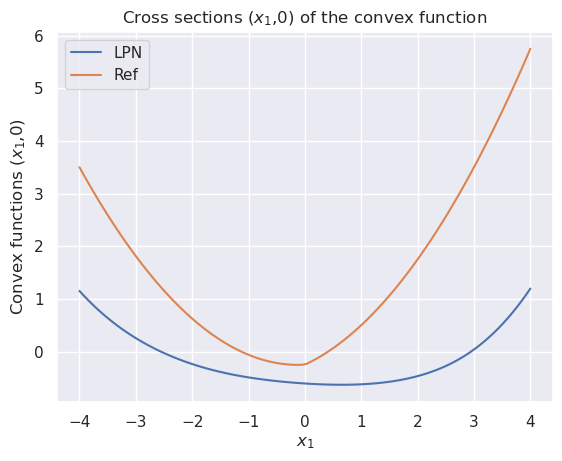

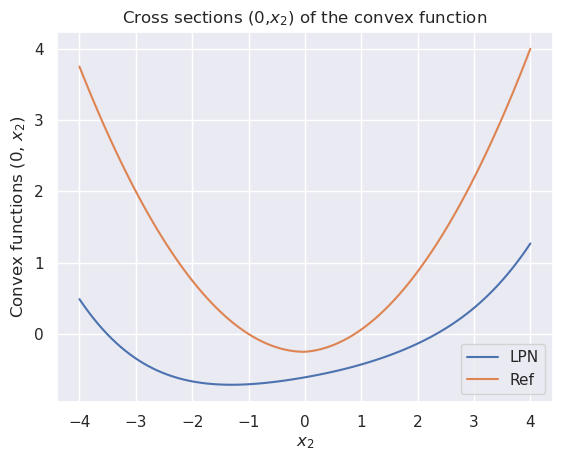

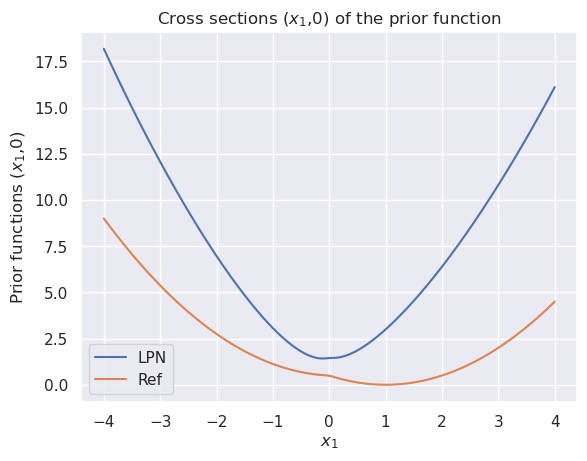

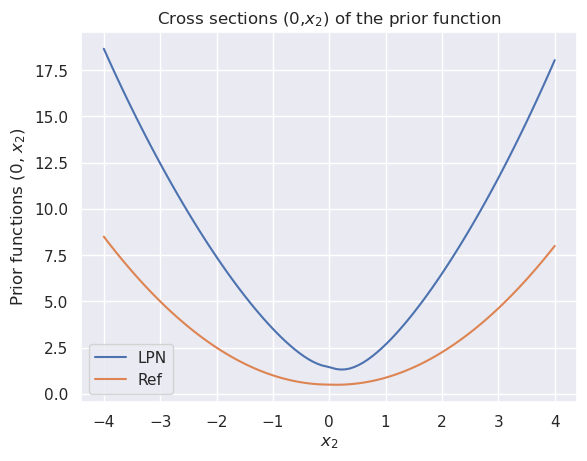

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN  ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")

iteration 0 loss 4506.435546875
iteration 0 loss 2042.343505859375


iteration 5000 loss 0.7917050719261169


iteration 10000 loss 0.1791243702173233


iteration 15000 loss 0.08191529661417007


iteration 20000 loss 0.046004973351955414


iteration 25000 loss 0.03427858278155327


iteration 30000 loss 0.02428588457405567


iteration 35000 loss 0.16645799577236176


iteration 40000 loss 0.016246868297457695


iteration 45000 loss 0.016784626990556717


iteration 50000 loss 0.010630865581333637


iteration 55000 loss 0.008946076966822147


iteration 60000 loss 0.007000759709626436


iteration 65000 loss 2.497467279434204


iteration 70000 loss 0.005489311181008816


iteration 75000 loss 0.0047469534911215305


iteration 80000 loss 0.004959026351571083


iteration 85000 loss 0.004047343973070383


iteration 90000 loss 0.0029936872888356447


iteration 95000 loss 0.0025920295156538486


Learning rate decreased to 0.0002 at iteration 100000
iteration 100000 loss 0.0025429006200283766


iteration 105000 loss 0.004640378523617983


iteration 110000 loss 0.0007396068540401757


iteration 115000 loss 0.00041551378672011197


iteration 120000 loss 0.0003036284469999373


iteration 125000 loss 0.00024759917869232595


iteration 130000 loss 0.00019784733012784272


iteration 135000 loss 0.00013849673268850893


iteration 140000 loss 0.0001067590928869322


iteration 145000 loss 8.252011321019381e-05


iteration 150000 loss 6.899781874381006e-05


iteration 155000 loss 5.771967698819935e-05


iteration 160000 loss 4.632497802958824e-05


iteration 165000 loss 3.875923721352592e-05


iteration 170000 loss 3.295737042208202e-05


iteration 175000 loss 2.99104031000752e-05


iteration 180000 loss 0.001950418809428811


iteration 185000 loss 2.1034900782979093e-05


iteration 190000 loss 1.8116870705853216e-05


iteration 195000 loss 1.7572014257893898e-05


Learning rate decreased to 4e-05 at iteration 200000
iteration 200000 loss 1.4251616448746063e-05


iteration 205000 loss 9.510678864899091e-06


iteration 210000 loss 7.209108389361063e-06


iteration 215000 loss 5.5866403272375464e-06


iteration 220000 loss 4.581458142638439e-06


iteration 225000 loss 6.784719971619779e-06


iteration 230000 loss 2.9016377993684728e-06


iteration 235000 loss 2.3363861600955715e-06


iteration 240000 loss 1.959205746970838e-06


iteration 245000 loss 1.6573250150031527e-06


iteration 250000 loss 1.304330226048478e-06


iteration 255000 loss 1.1536463944139541e-06


iteration 260000 loss 9.937784852809273e-07


iteration 265000 loss 7.382607805084263e-07


iteration 270000 loss 6.190430212882347e-07


iteration 275000 loss 5.334730985850911e-07


iteration 280000 loss 4.794798655893828e-07


iteration 285000 loss 4.122849531995598e-06


iteration 290000 loss 3.667630039672076e-07


iteration 295000 loss 0.0008725633379071951


Learning rate decreased to 8.000000000000001e-06 at iteration 300000
iteration 300000 loss 2.714600668696221e-07


iteration 305000 loss 2.10873054129479e-07


iteration 310000 loss 1.6818081860492384e-07


iteration 315000 loss 1.5123157481866656e-07


iteration 320000 loss 1.2402722404658562e-07


iteration 325000 loss 1.0496652436131626e-07


iteration 330000 loss 9.70231326391513e-08


iteration 335000 loss 8.325030620426332e-08


iteration 340000 loss 7.349058250838425e-08


iteration 345000 loss 7.093443343819672e-08


iteration 350000 loss 0.00043103774078190327


iteration 355000 loss 5.074437936514187e-08


iteration 360000 loss 4.465428915523262e-08


iteration 365000 loss 4.1955981799901565e-08


iteration 370000 loss 3.857438457544049e-08


iteration 375000 loss 3.365679646094577e-08


iteration 380000 loss 3.3534313104155444e-08


iteration 385000 loss 3.0553024998880574e-08


iteration 390000 loss 2.55191920928155e-08


iteration 395000 loss 2.5305133988240414e-08


Learning rate decreased to 1.6000000000000004e-06 at iteration 400000
iteration 400000 loss 2.1571292307953627e-08


iteration 405000 loss 1.8804092505320114e-08


iteration 410000 loss 1.6836015248600233e-08


iteration 415000 loss 1.56308264109839e-08


iteration 420000 loss 1.4765635825142454e-08


iteration 425000 loss 1.4006714010861288e-08


iteration 430000 loss 1.3515898622529221e-08


iteration 435000 loss 1.1976693414794681e-08


iteration 440000 loss 1.1995305193579497e-08


iteration 445000 loss 1.089556977973416e-08


iteration 450000 loss 1.01422568121734e-08


iteration 455000 loss 1.006708849615734e-08


iteration 460000 loss 9.283080082411743e-09


iteration 465000 loss 9.020469704523748e-09


iteration 470000 loss 8.359653413947399e-09


iteration 475000 loss 7.826921333276005e-09


iteration 480000 loss 7.446113503561946e-09


iteration 485000 loss 7.339360230673719e-09


iteration 490000 loss 6.868275281846081e-09


iteration 495000 loss 6.5317129482878045e-09


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


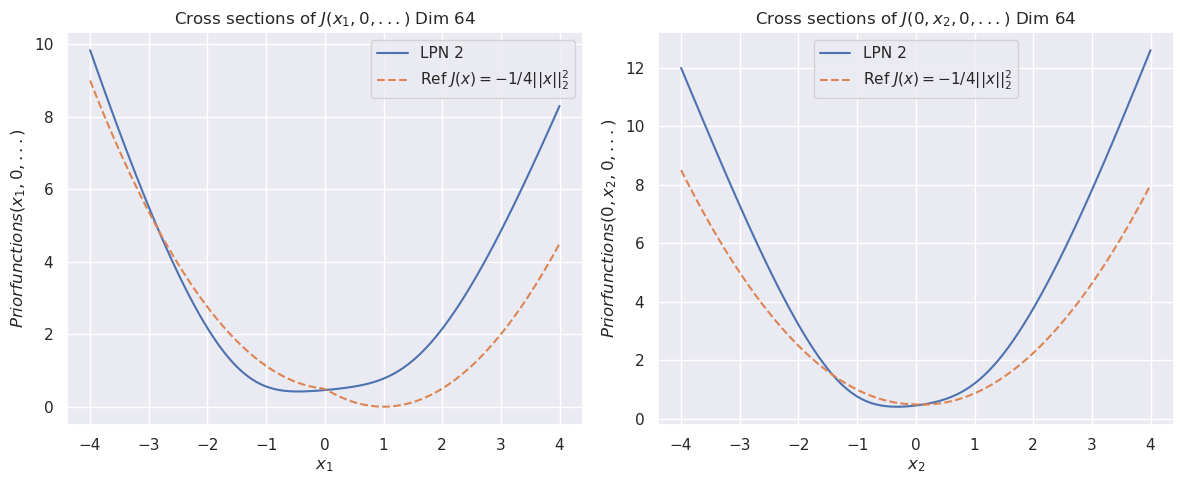

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)

    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)